The dataset is a custom one -> has a few catgories of landscapes. (Replace with any data in folderwise. One for each class.)

In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST, ImageFolder
from torchvision import datasets, transforms
from pytorch_lightning import Trainer
import torchvision.models as models
from collections import Counter
from pytorch_lightning import loggers as pl_loggers
import pickle
import os
os.environ["TORCH_HOME"] = "~/Desktop/Datasets/"

# Create model

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity



In [68]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes
        
        

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('train_acc_step', self.accuracy(preds, y))
        self.log('train_loss', loss)
#         self.log('avg_p_train', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        return loss
    

    def val_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('val_acc_step', self.accuracy(preds, y))
#         self.log('avg_p_val', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        self.log('val_loss', loss)
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        preds = self(x)
        self.log('test_acc_step', self.accuracy(preds, y))
#         self.log('avg_p_val', pl.metrics.functional.average_precision(preds, y,num_classes=self.num_classes))
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Load data

In [70]:
class ImDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_classes, data_dir: str = '/home/eragon/Desktop/Datasets/LandscapeSort/'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Augmentation policy
        self.augmentation = transforms.Compose([
              transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
              transforms.RandomRotation(degrees=15),
              transforms.RandomHorizontalFlip(),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        self.transform = transforms.Compose([
              transforms.Resize(size=256),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
        self.num_classes = num_classes

    def setup(self, stage=None):
        # build dataset
        im_dataset = ImageFolder(self.data_dir)
        # split dataset
        self.train, self.val, self.test = random_split(im_dataset, [80, 10, 9])
        self.train.dataset.transform = self.augmentation
        print(dict(Counter(self.train.dataset.targets)))
        print(self.train.dataset.class_to_idx)
        self.val.dataset.transform = self.transform
        self.test.dataset.transform = self.transform
        return self.train.dataset.class_to_idx
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=12)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=12)

In [71]:
dm = ImDataModule(batch_size=64,num_classes=5)
class_ids = dm.setup()

{0: 16, 1: 22, 2: 36, 3: 25}
{'Desert': 0, 'Fields': 1, 'Mountain': 2, 'Water': 3}


In [72]:
# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

# Logs

In [80]:
tensorboard --logdir ./lightning_logs

In [74]:
model = LitModel(( 3, 224, 224), 10)

In [75]:
tb_logger = pl_loggers.TensorBoardLogger('./lightning_logs/')

In [78]:
trainer = pl.Trainer(auto_select_gpus=True, gpus=1,
                     precision=16, profiler=False,max_epochs=100,
                    callbacks = [pl.callbacks.ProgressBar()],
                     automatic_optimization=True,logger = tb_logger,enable_pl_optimizer=True)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
Using environment variable NODE_RANK for node rank (0).
INFO:lightning:Using environment variable NODE_RANK for node rank (0).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
INFO:lightning:Using native 16bit precision.


In [79]:
trainer.fit(model, dm)


  | Name              | Type     | Params
-----------------------------------------------
0 | accuracy          | Accuracy | 0     
1 | feature_extractor | ResNet   | 11.7 M
2 | classifier        | Linear   | 10.0 K
-----------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
INFO:lightning:
  | Name              | Type     | Params
-----------------------------------------------
0 | accuracy          | Accuracy | 0     
1 | feature_extractor | ResNet   | 11.7 M
2 | classifier        | Linear   | 10.0 K
-----------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params


1

In [84]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc_step': tensor(0.4444, device='cuda:0'),
 'test_loss': tensor(1.5007, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc_step': 0.4444444477558136, 'test_loss': 1.5006747245788574}]

In [1]:
trainer.save_checkpoint('model1.ckpt')

NameError: name 'trainer' is not defined

In [85]:
with open("class_ids.pkl","wb+") as f:
    pickle.dump(class_ids, f)

# Inference

In [86]:
from PIL import Image

In [87]:
with open("class_ids.pkl","rb+") as f:
    class_ids = pickle.load(f)

In [88]:
transform = transforms.Compose([
              transforms.Resize(size=256),
              transforms.CenterCrop(size=224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

In [89]:
class_ids = {v: k for k, v in class_ids.items()}
class_ids

{0: 'Desert', 1: 'Fields', 2: 'Mountain', 3: 'Water'}

In [90]:
m1 = LitModel.load_from_checkpoint('model1.ckpt')

In [99]:
t_path = "/home/eragon/Documents/ArtReferences/Landscapes/Desert/00000016_(6).jpg"

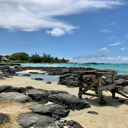

In [100]:
im_sh = Image.open(t_path).convert('RGB');im_sh.resize((128,128))

In [101]:
test = transform(im_sh).unsqueeze(0)

In [102]:
pred = class_ids[int(torch.argmax(m1(test), 1))];pred

'Fields'